In [2]:
# importing the libraries
import torch, torchvision, os, PIL, pdb
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import glob
from PIL import Image, ExifTags
import colorsys
import random
import pylab
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.optim as optim
from tqdm.notebook import tqdm
import os
import random
from IPython import display
import ignite
from ignite.engine import Engine, Events
import ignite.distributed as idist
from ignite.metrics import FID, InceptionScore
from ignite.contrib.handlers import ProgressBar
import warnings

warnings.filterwarnings("ignore")

def show(tensor, num=25, wandbactive=0, name=''):
    data = tensor.detach().cpu()
    grid = make_grid(data[:num], nrow=5).permute(1,2,0)

    plt.imshow(grid.clip(0,1))
    plt.axis('off')
    plt.show()
    plt.axis('off')
    

In [2]:
### Global parameters
n_epochs=45
batch_size=64
image_size = 128
lr=1e-4
z_dim=200
device='cuda' #GPU
tag='WGAN_cracks'
data_path='data_crops_cracks/crackSubImageForTraining/130BY130/accept'

### W-GAN
crit_cycles=5
show_step=100
save_step=100

In [3]:
# generator model
# https://medium.com/@ideami

class Generator(nn.Module):
    def __init__(self, z_dim=64, d_dim=16):
        super(Generator, self).__init__()
        self.z_dim=z_dim

        self.gen = nn.Sequential(
                ## ConvTranspose2d: in_channels, out_channels, kernel_size, stride=1, padding=0
                ## Calculating new width and height: (n-1)*stride -2*padding +ks
                ## n = width or height
                ## ks = kernel size
                ## we begin with a 1x1 image with z_dim number of channels (200)
                nn.ConvTranspose2d(z_dim, d_dim * 32, 4, 1, 0), ## 4x4 (ch: 200, 512)
                nn.BatchNorm2d(d_dim*32),
                nn.ReLU(True),

                nn.ConvTranspose2d(d_dim*32, d_dim*16, 4, 2, 1), ## 8x8 (ch: 512, 256)
                nn.BatchNorm2d(d_dim*16),
                nn.ReLU(True),

                nn.ConvTranspose2d(d_dim*16, d_dim*8, 4, 2, 1), ## 16x16 (ch: 256, 128)
                #(n-1)*stride -2*padding +ks = (8-1)*2-2*1+4=16
                nn.BatchNorm2d(d_dim*8),
                nn.ReLU(True),

                nn.ConvTranspose2d(d_dim*8, d_dim*4, 4, 2, 1), ## 32x32 (ch: 128, 64)
                nn.BatchNorm2d(d_dim*4),
                nn.ReLU(True),            

                nn.ConvTranspose2d(d_dim*4, d_dim*2, 4, 2, 1), ## 64x64 (ch: 64, 32)
                nn.BatchNorm2d(d_dim*2),
                nn.ReLU(True),            

                nn.ConvTranspose2d(d_dim*2, 3, 4, 2, 1), ## 128x128 (ch: 32, 3)
                nn.Tanh() ### produce result in the range from -1 to 1
        )


    def forward(self, noise):
        x=noise.view(len(noise), self.z_dim, 1, 1)  # 128 x 200 x 1 x 1
        return self.gen(x)


def gen_noise(num, z_dim, device='cuda'):
    return torch.randn(num, z_dim, device=device) # 128 x 200



In [4]:
## critic model

class Critic(nn.Module):
    def __init__(self, d_dim=16):
        super(Critic, self).__init__()

        self.crit = nn.Sequential(
          # Conv2d: in_channels, out_channels, kernel_size, stride=1, padding=0
          ## New width and height: # (n+2*pad-ks)//stride +1
          nn.Conv2d(3, d_dim, 4, 2, 1), #(n+2*pad-ks)//stride +1 = (128+2*1-4)//2+1=64x64 (ch: 3,16)
          nn.InstanceNorm2d(d_dim), 
          nn.LeakyReLU(0.2),

          nn.Conv2d(d_dim, d_dim*2, 4, 2, 1), ## 32x32 (ch: 16, 32)
          nn.InstanceNorm2d(d_dim*2), 
          nn.LeakyReLU(0.2),

          nn.Conv2d(d_dim*2, d_dim*4, 4, 2, 1), ## 16x16 (ch: 32, 64)
          nn.InstanceNorm2d(d_dim*4), 
          nn.LeakyReLU(0.2),

          nn.Conv2d(d_dim*4, d_dim*8, 4, 2, 1), ## 8x8 (ch: 64, 128)
          nn.InstanceNorm2d(d_dim*8), 
          nn.LeakyReLU(0.2),

          nn.Conv2d(d_dim*8, d_dim*16, 4, 2, 1), ## 4x4 (ch: 128, 256)
          nn.InstanceNorm2d(d_dim*16), 
          nn.LeakyReLU(0.2),

          nn.Conv2d(d_dim*16, 1, 4, 1, 0), #(n+2*pad-ks)//stride +1=(4+2*0-4)//1+1= 1X1 (ch: 256,1)

        )


    def forward(self, image):
        # image: 128 x 3 x 128 x 128
        crit_pred = self.crit(image) # 128 x 1 x 1 x 1
        return crit_pred.view(len(crit_pred),-1) ## 128 x 1  
  

# Optimizers

In [5]:
gen = Generator(z_dim=200).to(device)
crit = Critic().to(device)
# Different optimizer options for generator and discriminator
crit_opt = optim.Adam(crit.parameters(), lr=1e-4, betas=(0.5, 0.9))
gen_opt = optim.Adam(gen.parameters(), lr=1e-4, betas=(0.5, 0.9))

# DataLoader

In [6]:
## optional, init your weights in different ways
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias,0)

    if isinstance(m,nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias,0)

In [7]:
class image_loader(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path=''):
        'Initialization'
        self.transform = transform
        self.image_paths = glob.glob(data_path+'/*.jpg')
        if train:
            self.image_paths = self.image_paths[0:int(0.9*len(self.image_paths))]
        else:
            self.image_paths = self.image_paths[int(0.9*len(self.image_paths)):]
        self.labels_dict = {"accept":0}
        self.inv_labels_dict = {v: k for k, v in self.labels_dict.items()}
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        
        X = self.transform(image)
        y = self.labels_dict[image_path.split("/")[-2]]
        
        return X, y


train_transform = transforms.Compose([transforms.Resize((image_size, image_size)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
                                    )

trainset = image_loader(train=True, transform=train_transform,
                        data_path=data_path)
train_dataloader = DataLoader(trainset, shuffle=True, batch_size=batch_size,
                              num_workers=12, drop_last=True)

testset = image_loader(train=False, transform=train_transform,
                       data_path=data_path)
test_dataloader = DataLoader(testset, batch_size=batch_size,
                             num_workers=12, drop_last=True)

Train set length:  7555
Test set length:  840


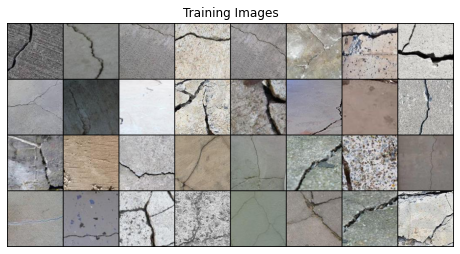

In [8]:
print("Train set length: ", len(train_dataloader.dataset))
print("Test set length: ", len(test_dataloader.dataset))


real_batch = next(iter(train_dataloader))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:32], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Evaluation metrics

In [9]:
fid_metric = FID(device=device)
is_metric = InceptionScore(device=device, output_transform=lambda x: x[0])

In [10]:
## gradient penalty calculation

def get_gp(real, fake, crit, alpha, gamma=10):
    mix_images = real * alpha + fake * (1-alpha) # 128 x 3 x 128 x 128
    mix_scores = crit(mix_images) # 128 x 1

    gradient = torch.autograd.grad(
      inputs = mix_images,
      outputs = mix_scores,
      grad_outputs=torch.ones_like(mix_scores),
      retain_graph=True,
      create_graph=True,
    )[0] # 128 x 3 x 128 x 128

    gradient = gradient.view(len(gradient), -1)   # 128 x 49152
    gradient_norm = gradient.norm(2, dim=1) 
    gp = gamma * ((gradient_norm-1)**2).mean()

    return gp

## Interpolate dataset images to 299x299x3 to be able to work with IS and FID prebuilt functions
def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)

## Apply interpolation to fake and real batch images
def evaluation_step(Engine, batch):
    with torch.no_grad():
        noise = gen_noise(len(batch[0]), z_dim)
        gen.eval()
        fake_batch = gen(noise)
        fake = interpolate(fake_batch)
        real = interpolate(batch[0])
        return fake, real

In [11]:
evaluator = Engine(evaluation_step)
is_metric.attach(evaluator, "is")
fid_metric.attach(evaluator, "fid")

# Training

In [12]:
def training_losses(gen_losses, crit_losses, cur_step, show_step):
    gen_mean=sum(gen_losses[-show_step:]) / show_step
    crit_mean = sum(crit_losses[-show_step:]) / show_step
    print(f"Epoch: {epoch}: Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
    

In [13]:
def evaluate_fid_is():
    evaluator.run(test_dataloader,max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    is_score = metrics['is']
    print(f"*   FID : {fid_score:4f}")
    print(f"*    IS : {is_score:4f}")

In [14]:
## Save and load checkpoints

if not os.path.exists(f'./info/{tag}/'):
    os.mkdir(f'./info/{tag}/')
root_path=f'./info/{tag}/'

def save_checkpoint(name):
    torch.save({
      'epoch': epoch,
      'gen_losses': gen_losses,
      'crit_losses': crit_losses,
      'fids': evaluator.state.metrics['fid'],
      'iss': evaluator.state.metrics['is'],        
      'model_state_dict': gen.state_dict(),
      'optimizer_state_dict': gen_opt.state_dict()      
    }, f"{root_path}G-{name}.pkl")

    torch.save({
      'epoch': epoch,
      'crit_losses': crit_losses,
      'fids': evaluator.state.metrics['fid'],
      'iss': evaluator.state.metrics['is'],
      'model_state_dict': crit.state_dict(),
      'optimizer_state_dict': crit_opt.state_dict()      
    }, f"{root_path}C-{name}.pkl")
  
    print("Saved checkpoint")

def load_checkpoint(name):
    checkpoint = torch.load(f"{root_path}G-{name}.pkl")
    gen.load_state_dict(checkpoint['model_state_dict'])
    gen_opt.load_state_dict(checkpoint['optimizer_state_dict'])

    checkpoint = torch.load(f"{root_path}C-{name}.pkl")
    crit.load_state_dict(checkpoint['model_state_dict'])
    crit_opt.load_state_dict(checkpoint['optimizer_state_dict'])

    print("Loaded checkpoint")

#load_checkpoint('final-wgan-noinit')

*   FID : 0.077765
*    IS : 1.755961


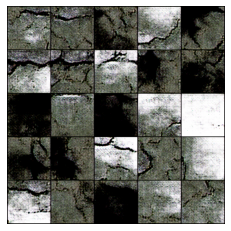

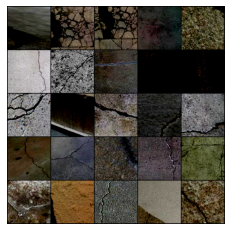

Epoch: 12: Step 1470: Generator loss: 14.528789574759347, critic loss: -7.906747801644461
Saving checkpoint:  1505 35
Saved checkpoint
*   FID : 0.100508
*    IS : 1.816379


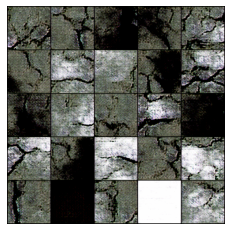

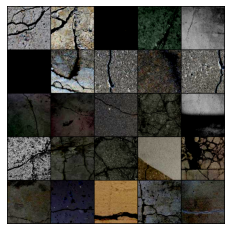

Epoch: 12: Step 1505: Generator loss: 13.976483644757952, critic loss: -7.936913106100901


  0%|          | 0/118 [00:00<?, ?it/s]

Saving checkpoint:  1540 35
Saved checkpoint
*   FID : 0.062322
*    IS : 1.576796


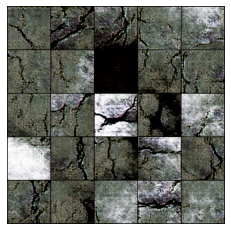

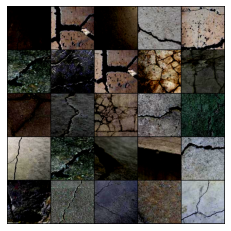

Epoch: 13: Step 1540: Generator loss: 14.1004757472447, critic loss: -8.315818255288258
Saving checkpoint:  1575 35
Saved checkpoint
*   FID : 0.059952
*    IS : 1.694189


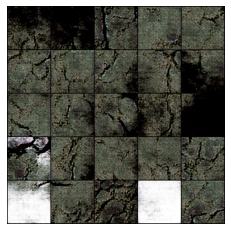

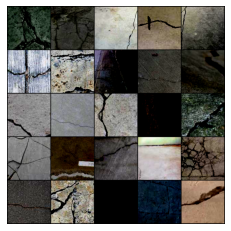

Epoch: 13: Step 1575: Generator loss: 12.675321933201381, critic loss: -7.528592027936663
Saving checkpoint:  1610 35
Saved checkpoint
*   FID : 0.078541
*    IS : 1.550444


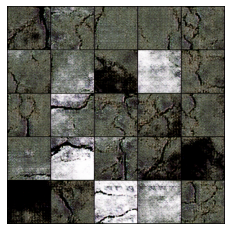

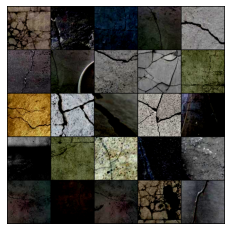

Epoch: 13: Step 1610: Generator loss: 13.711474364144461, critic loss: -7.606922427586148
Saving checkpoint:  1645 35
Saved checkpoint
*   FID : 0.065570
*    IS : 1.663720


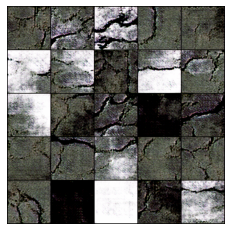

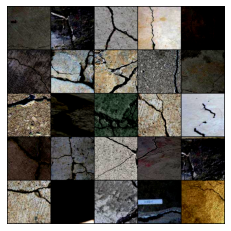

Epoch: 13: Step 1645: Generator loss: 12.103515352521624, critic loss: -7.297567344393048


  0%|          | 0/118 [00:00<?, ?it/s]

Saving checkpoint:  1680 35
Saved checkpoint
*   FID : 0.057147
*    IS : 1.823803


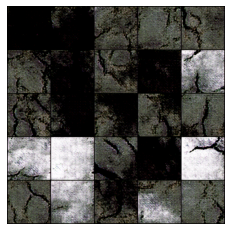

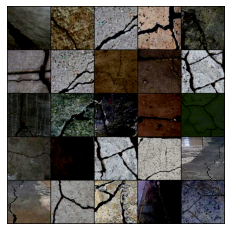

Epoch: 14: Step 1680: Generator loss: 13.523222405569895, critic loss: -7.81343899863107
Saving checkpoint:  1715 35
Saved checkpoint
*   FID : 0.053975
*    IS : 1.674066


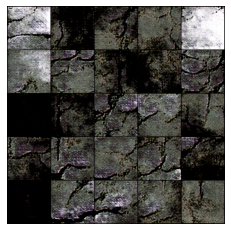

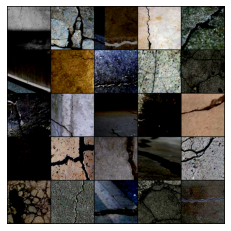

Epoch: 14: Step 1715: Generator loss: 12.519823919023786, critic loss: -6.9829152597699835
Saving checkpoint:  1750 35
Saved checkpoint
*   FID : 0.058536
*    IS : 1.725087


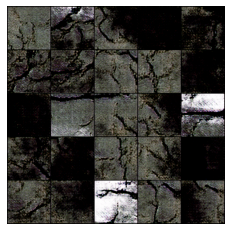

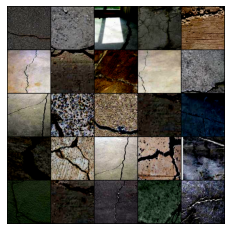

Epoch: 14: Step 1750: Generator loss: 12.461228316170828, critic loss: -7.52685909135001


  0%|          | 0/118 [00:00<?, ?it/s]

Saving checkpoint:  1785 35
Saved checkpoint
*   FID : 0.054849
*    IS : 1.611012


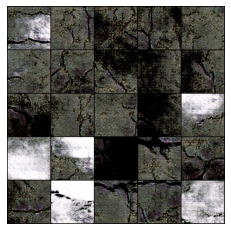

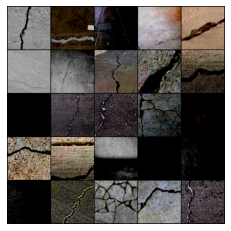

Epoch: 15: Step 1785: Generator loss: 11.311543600899833, critic loss: -6.680043893541608
Saving checkpoint:  1820 35
Saved checkpoint
*   FID : 0.068833
*    IS : 1.896149


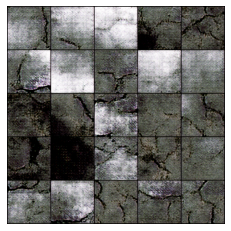

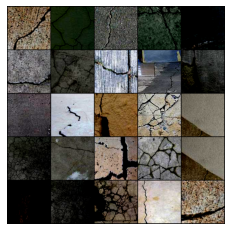

Epoch: 15: Step 1820: Generator loss: 11.527706377846854, critic loss: -7.059884125845773
Saving checkpoint:  1855 35
Saved checkpoint
*   FID : 0.057520
*    IS : 1.570018


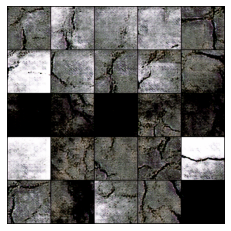

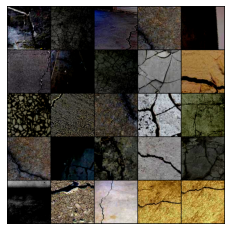

Epoch: 15: Step 1855: Generator loss: 12.48286440713065, critic loss: -7.453724046434674


  0%|          | 0/118 [00:00<?, ?it/s]

Saving checkpoint:  1890 35
Saved checkpoint
*   FID : 0.053151
*    IS : 1.800458


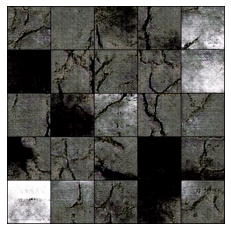

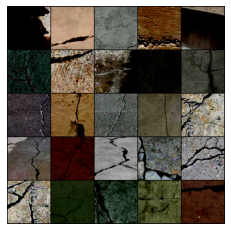

Epoch: 16: Step 1890: Generator loss: 11.619470637185232, critic loss: -7.3170208372388545
Saving checkpoint:  1925 35
Saved checkpoint
*   FID : 0.050669
*    IS : 1.644117


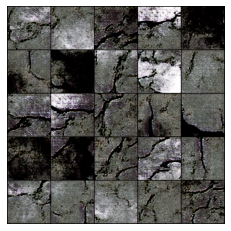

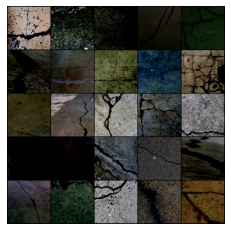

Epoch: 16: Step 1925: Generator loss: 10.626198741367885, critic loss: -6.99066057750157
Saving checkpoint:  1960 35
Saved checkpoint
*   FID : 0.050515
*    IS : 1.769081


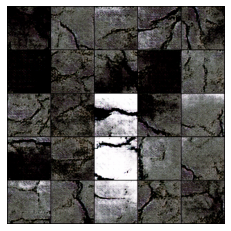

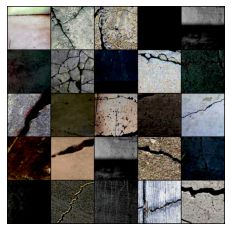

Epoch: 16: Step 1960: Generator loss: 10.637179633549282, critic loss: -6.819879294804163
Saving checkpoint:  1995 35
Saved checkpoint
*   FID : 0.053813
*    IS : 1.716128


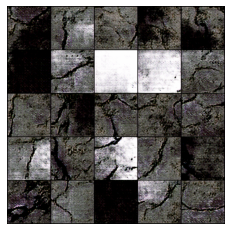

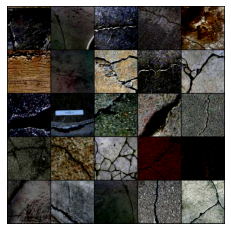

Epoch: 16: Step 1995: Generator loss: 11.339935915810722, critic loss: -6.9566464642116


  0%|          | 0/118 [00:00<?, ?it/s]

Saving checkpoint:  2030 35
Saved checkpoint
*   FID : 0.050421
*    IS : 1.973954


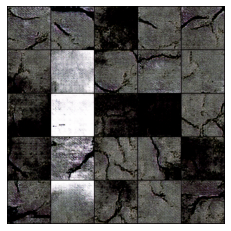

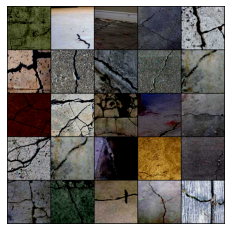

Epoch: 17: Step 2030: Generator loss: 10.29551466533116, critic loss: -7.346853722163608
Saving checkpoint:  2065 35
Saved checkpoint
*   FID : 0.068310
*    IS : 1.710549


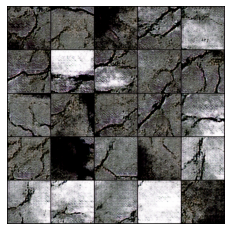

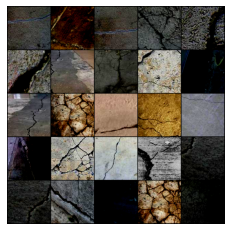

Epoch: 17: Step 2065: Generator loss: 10.301767553601946, critic loss: -6.470292295728413
Saving checkpoint:  2100 35
Saved checkpoint
*   FID : 0.050431
*    IS : 1.766642


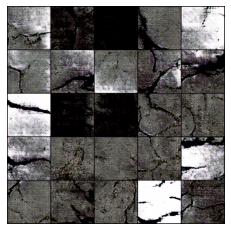

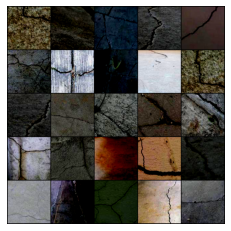

Epoch: 17: Step 2100: Generator loss: 10.579763167245048, critic loss: -6.9968686621529725


  0%|          | 0/118 [00:00<?, ?it/s]

KeyboardInterrupt: 

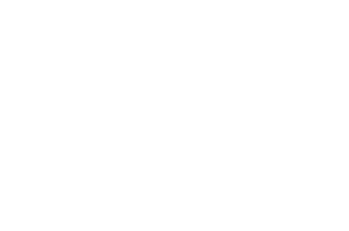

In [15]:
## Training loop 
gen_losses=[]
crit_losses=[]
cur_step=0
for epoch in range(n_epochs):
    for real, _ in tqdm(train_dataloader):
        cur_bs= len(real) #128
        real=real.to(device)

        ### CRITIC
        mean_crit_loss = 0
        for _ in range(crit_cycles):
            crit_opt.zero_grad()

            noise=gen_noise(cur_bs, z_dim)
            fake = gen(noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            alpha=torch.rand(len(real),1,1,1,device=device, requires_grad=True) # 128 x 1 x 1 x 1
            gp = get_gp(real, fake.detach(), crit, alpha)

            crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp

            mean_crit_loss+=crit_loss.item() / crit_cycles

            crit_loss.backward(retain_graph=True)
            crit_opt.step()

        crit_losses+=[mean_crit_loss]

        ### GENERATOR
        gen_opt.zero_grad()
        noise = gen_noise(cur_bs, z_dim)
        fake = gen(noise)
        crit_fake_pred = crit(fake)

        gen_loss = -crit_fake_pred.mean()
        gen_loss.backward()
        gen_opt.step()

        gen_losses+=[gen_loss.item()]

        ### STATS  
        if (cur_step % show_step == 0 and cur_step > 0):
            evaluate_fid_is()
            show(fake, wandbactive=1, name='fake')
            show(real, wandbactive=1, name='real')
            training_losses(gen_losses, crit_losses, cur_step, show_step)
            
            print("Saving checkpoint: ", cur_step, save_step)
            save_checkpoint("latest")

        cur_step+=1


In [ ]:
plt.imshow(fake[16].detach().cpu().permute(1,2,0).squeeze().clip(0,1))

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

# MORPHING, interpolation between points in latent space
gen_set=[]
z_shape=[1,200,1,1]
rows=4
steps=17

for i in range(rows):
  z1,z2 = torch.randn(z_shape), torch.randn(z_shape)
  for alpha in np.linspace(0,1,steps):
    z=alpha*z1 + (1-alpha)*z2
    res=gen(z.cuda())[0]
    gen_set.append(res)

fig = plt.figure(figsize=(25,11))
grid=ImageGrid(fig, 111, nrows_ncols=(rows,steps), axes_pad=0.1)

for ax , img in zip (grid, gen_set):
  ax.axis('off')
  res=img.cpu().detach().permute(1,2,0)
  res=res-res.min()
  res=res/(res.max()-res.min())
  ax.imshow(res.clip(0,1.0))

plt.show()